In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (3178).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (3561).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (900).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1148).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (268).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S

# import Libraries 

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout , Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import random
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
base_dir = r'/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'


In [4]:
classes = ['Cyst', 'Tumor', 'Stone', 'Normal']


In [5]:
data = []
for label in classes:
    folder_path = os.path.join(base_dir, label)
    for file in os.listdir(folder_path):
        if file.endswith(('jpg')):  
            file_path = os.path.join(folder_path, file)
            data.append((file_path, label))

In [6]:
df = pd.DataFrame(data, columns=['file_path', 'label'])

In [7]:
df.head()

file_path label
0  /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Cyst
1  /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Cyst
2  /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Cyst
3  /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Cyst
4  /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Cyst

In [8]:
df.shape

(12446, 2)

In [9]:
df['label'].value_counts()

label
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64

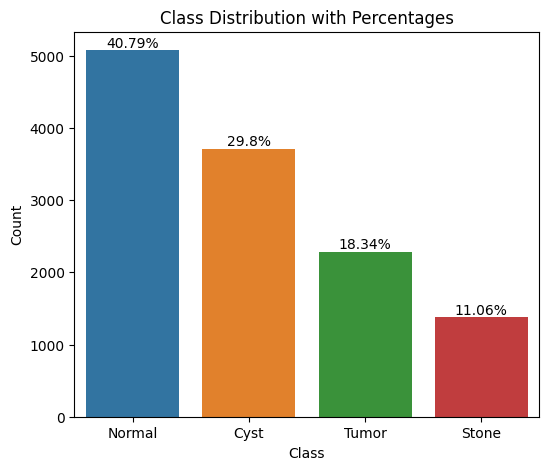

In [10]:
value_counts = df['label'].value_counts().reset_index()
value_counts.columns = ['label', 'count']
value_counts['percentage'] = (value_counts['count'] / value_counts['count'].sum() * 100).round(2)
plt.figure(figsize=(6,5))
ax = sns.barplot(data=value_counts, x='label', y='count')
for i, row in value_counts.iterrows():
    ax.text(i, row['count'], f"{row['percentage']}%", ha='center', va='bottom', fontsize=10, color='black')

plt.title("Class Distribution with Percentages")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

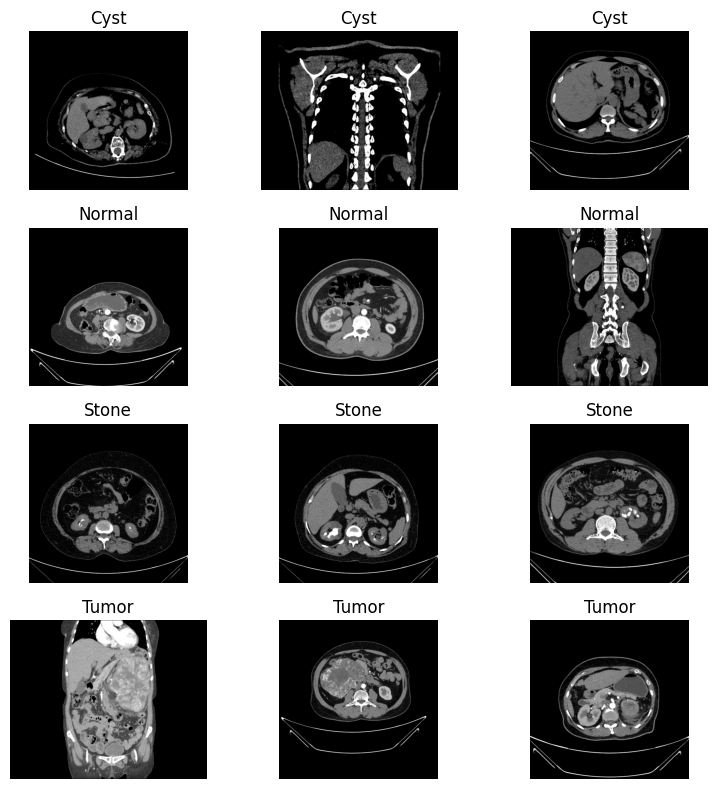

In [11]:
classes_to_display = ['Cyst', 'Normal', 'Stone', 'Tumor']
fig, axes = plt.subplots(4, 3, figsize=(8, 8))  
axes = axes.flatten()  

for i, label in enumerate(classes_to_display):
    class_data = df[df['label'] == label]
    sample_images = random.sample(list(class_data['file_path']), 3)
    
    for j, img_path in enumerate(sample_images):
        img = mpimg.imread(img_path) 
        axes[i * 3 + j].imshow(img)  
        axes[i * 3 + j].axis('off')  
        axes[i * 3 + j].set_title(label)  
plt.tight_layout()
plt.show()

In [12]:
df['binary_label'] = df['label'].apply(lambda x: 0 if x == 'Normal' else 1)


In [13]:
df.head()

file_path label  binary_label
0  /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Cyst             1
1  /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Cyst             1
2  /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Cyst             1
3  /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Cyst             1
4  /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Cyst             1

In [14]:
df['binary_label'].value_counts()


binary_label
1    7369
0    5077
Name: count, dtype: int64

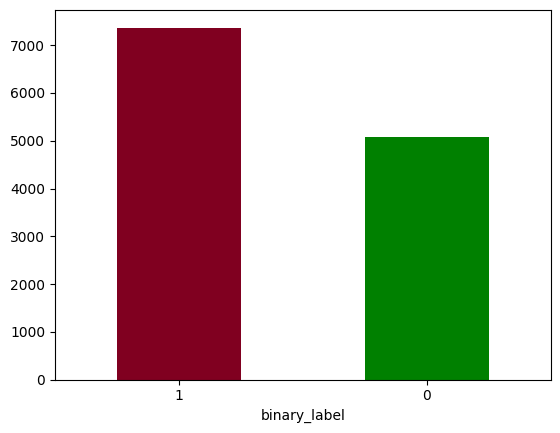

In [15]:
value_counts = df['binary_label'].value_counts()
ax = value_counts.plot(kind='bar', color=['#800020', 'green'])
plt.xticks(rotation=360)
plt.grid(False)

plt.show()


In [16]:
df['label'].value_counts()


label
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64

# undersampling 

> ***tyr to make the data balanced***
> 
> ***delete from the cyst categroy 1500 image to make normal and upnormal close to each other***

In [17]:
df = df.drop(df[df['label'] == 'Cyst'].head(1500).index)

In [18]:
df['label'].value_counts()

label
Normal    5077
Tumor     2283
Cyst      2209
Stone     1377
Name: count, dtype: int64

In [19]:
df['binary_label'].value_counts()

binary_label
1    5869
0    5077
Name: count, dtype: int64

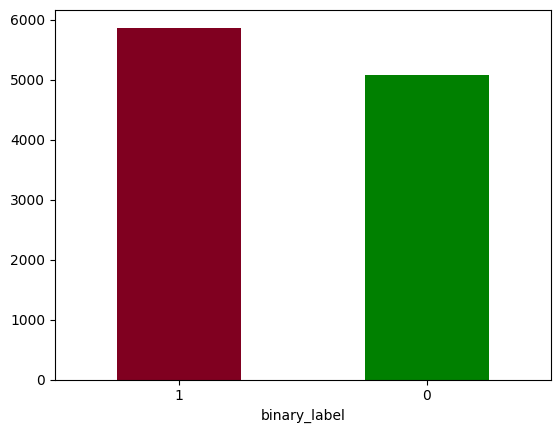

In [20]:
value_counts = df['binary_label'].value_counts()
ax = value_counts.plot(kind='bar', color=['#800020', 'green'])
plt.xticks(rotation=360)
plt.grid(False)

plt.show()


# split data

***split data into train 90% , val 5% , test 5%***


In [21]:
train_df, temp_df = train_test_split(df, test_size=0.1, stratify=df['binary_label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['binary_label'], random_state=42)

In [22]:
print(f"Training size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Testing size: {len(test_df)}")

Training size: 9851
Validation size: 547
Testing size: 548


In [23]:
train_df

file_path   label  binary_label
9398   /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Normal             0
2554   /kaggle/input/ct-kidney-dataset-normal-cyst-tu...    Cyst             1
5121   /kaggle/input/ct-kidney-dataset-normal-cyst-tu...   Tumor             1
2002   /kaggle/input/ct-kidney-dataset-normal-cyst-tu...    Cyst             1
7494   /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Normal             0
...                                                  ...     ...           ...
10772  /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Normal             0
9335   /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Normal             0
10051  /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Normal             0
4311   /kaggle/input/ct-kidney-dataset-normal-cyst-tu...   Tumor             1
2075   /kaggle/input/ct-kidney-dataset-normal-cyst-tu...    Cyst             1

[9851 rows x 3 columns]

In [24]:
train_df['binary_label'].value_counts()

binary_label
1    5282
0    4569
Name: count, dtype: int64

# preprocessing 

In [25]:
train_df['binary_label'] = train_df['binary_label'].astype(str)
val_df['binary_label'] = val_df['binary_label'].astype(str)
test_df['binary_label'] = test_df['binary_label'].astype(str)

In [26]:
datagen = ImageDataGenerator(rescale=1.0/255)

In [27]:
binary_train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='binary_label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 9851 validated image filenames belonging to 2 classes.


In [28]:
binary_val_gen = datagen.flow_from_dataframe(
    val_df,
    x_col='file_path',
    y_col='binary_label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 547 validated image filenames belonging to 2 classes.


In [29]:
binary_test_gen = datagen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='binary_label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 548 validated image filenames belonging to 2 classes.


# model 

> ***binary model*** 

> i have input shape that (22, 224 , 3 ) 3 for RGB
 
> 5 CNN layers

> 2 ANN layers

> binary output with sigmoid function

In [30]:
binary_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(16, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


In [31]:
binary_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,609 (2.47 MB)

 Trainable params: 648,609 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
binary_model.compile(optimizer=Adam(learning_rate=0.00001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [34]:
history = binary_model.fit(
    binary_train_gen,
    epochs=10,
    validation_data=binary_val_gen,
    callbacks=[early_stopping]
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734733453.259208      70 service.cc:145] XLA service 0x7df6cc003f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734733453.259284      70 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/154 ━━━━━━━━━━━━━━━━━━━━ 31:03 12s/step - accuracy: 0.5000 - loss: 0.6955

I0000 00:00:1734733458.411672      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


154/154 ━━━━━━━━━━━━━━━━━━━━ 106s 616ms/step - accuracy: 0.5484 - loss: 0.6845 - val_accuracy: 0.6819 - val_loss: 0.6365
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 49s 303ms/step - accuracy: 0.7566 - loss: 0.5960 - val_accuracy: 0.8519 - val_loss: 0.4688
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 48s 299ms/step - accuracy: 0.8503 - loss: 0.4343 - val_accuracy: 0.8647 - val_loss: 0.3735
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 47s 293ms/step - accuracy: 0.8669 - loss: 0.3593 - val_accuracy: 0.8812 - val_loss: 0.3207
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 49s 305ms/step - accuracy: 0.8862 - loss: 0.3058 - val_accuracy: 0.8958 - val_loss: 0.2781
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 48s 298ms/step - accuracy: 0.9095 - loss: 0.2624 - val_accuracy: 0.9214 - val_loss: 0.2378
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 49s 305ms/step - accuracy: 0.9317 - loss: 0.2248 - val_accuracy: 0.9287 - val_loss: 0.2053
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 49s 304ms/step - accuracy: 0.9406 - loss: 0.1889 - va

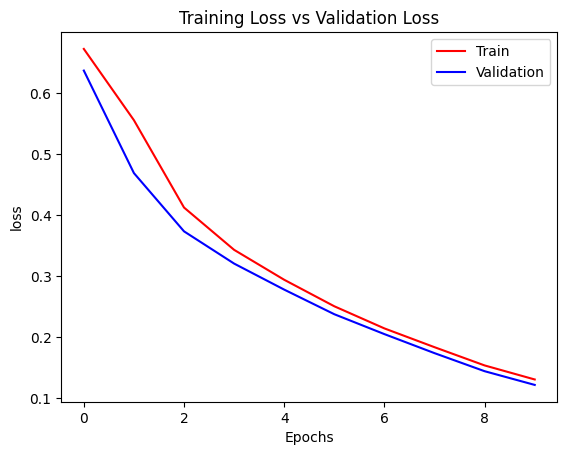

In [35]:
plt.title('Training Loss vs Validation Loss')
plt.plot(history.history['loss'], color='red', label='Train')
plt.plot(history.history['val_loss'], color='blue', label='Validation')

plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

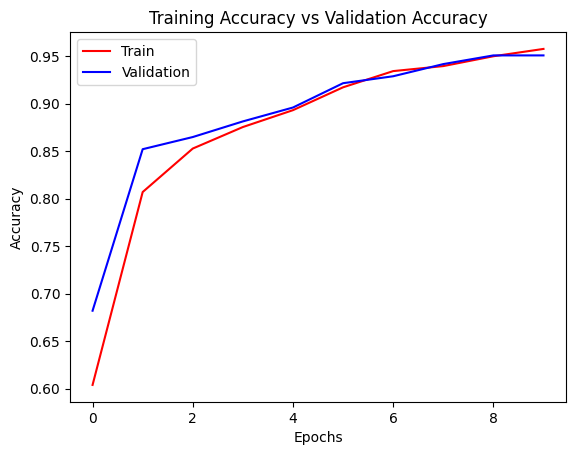

In [36]:
plt.title('Training Accuracy vs Validation Accuracy')
plt.plot(history.history['accuracy'], color='red', label='Train')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

> ***evaluation***

In [37]:
test_loss_binary, test_accuracy_binary = binary_model.evaluate(binary_test_gen)

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 616ms/step - accuracy: 0.9540 - loss: 0.1268


In [38]:
print(f"Loss: {test_loss_binary}")
print(f"Accuracy: {test_accuracy_binary}")

Loss: 0.12383384257555008
Accuracy: 0.9525547623634338


In [39]:
y_pred = binary_model.predict(binary_test_gen)  

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step


In [40]:
y_true = binary_test_gen.classes

In [41]:
results_df_pro = pd.DataFrame({
    'True_Label': y_true,
    'Predicted_Label': y_pred.flatten()
})

In [42]:
results_df_pro

True_Label  Predicted_Label
0             1         0.752915
1             0         0.113917
2             1         0.993812
3             1         0.884141
4             1         0.999949
..          ...              ...
543           0         0.051720
544           1         1.000000
545           1         0.868800
546           1         0.879542
547           1         0.986316

[548 rows x 2 columns]

In [43]:
y_pred = (y_pred > 0.5).astype(int)

In [44]:
results_df = pd.DataFrame({
    'True_Label': y_true,
    'Predicted_Label': y_pred.flatten()
})

In [45]:
results_df.head(10)

True_Label  Predicted_Label
0           1                1
1           0                0
2           1                1
3           1                1
4           1                1
5           1                0
6           0                0
7           0                0
8           0                0
9           1                1

In [46]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       254
           1       0.97      0.94      0.96       294

    accuracy                           0.95       548
   macro avg       0.95      0.95      0.95       548
weighted avg       0.95      0.95      0.95       548



In [47]:
cm = confusion_matrix(y_true, y_pred)

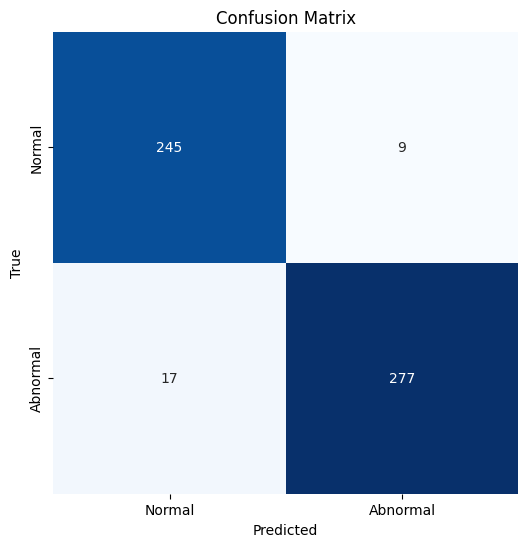

In [48]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

> show some images

In [49]:
sample_images, sample_labels = next(binary_test_gen)

In [50]:
sample_predictions = binary_model.predict(sample_images)
sample_predictions = (sample_predictions > 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  


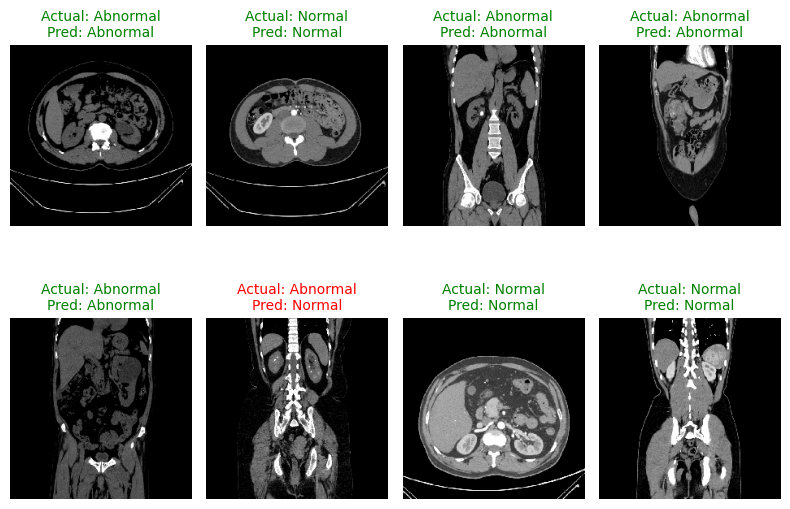

In [51]:
num_images = 8  
plt.figure(figsize=(8, 6))
rows, cols = 2, 4 
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(sample_images[i])
    actual_label = 'Normal' if sample_labels[i] == 0 else 'Abnormal'
    predicted_label = 'Normal' if sample_predictions[i] == 0 else 'Abnormal'
    label_color = "green" if sample_labels[i] == sample_predictions[i] else "red"
    plt.title(
        f"Actual: {actual_label}\nPred: {predicted_label}",
        color=label_color, 
        fontsize=10
    )
    
    plt.axis("off")  
    
plt.tight_layout()
plt.show()


> ***classification model***

In [52]:
abnormal_df = df[df['label'].isin(['Cyst', 'Stone', 'Tumor'])]

In [53]:
abnormal_df.head()

file_path label  binary_label
1500  /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Cyst             1
1501  /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Cyst             1
1502  /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Cyst             1
1503  /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Cyst             1
1504  /kaggle/input/ct-kidney-dataset-normal-cyst-tu...  Cyst             1

In [54]:
abnormal_df.shape

(5869, 3)

In [55]:
abnormal_df['label'].value_counts()

label
Tumor    2283
Cyst     2209
Stone    1377
Name: count, dtype: int64

In [56]:
abnormal_df['binary_label'].value_counts()

binary_label
1    5869
Name: count, dtype: int64

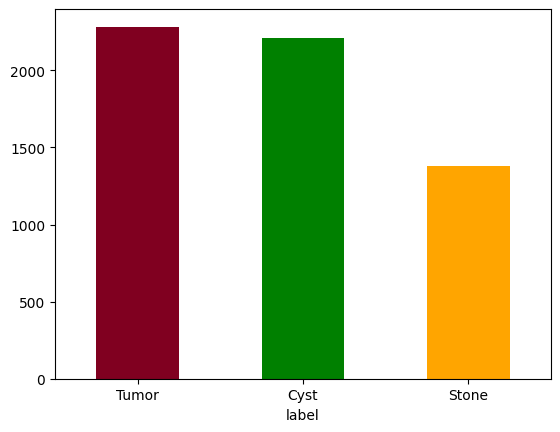

In [57]:
value_counts = abnormal_df['label'].value_counts()
ax = value_counts.plot(kind='bar', color=['#800020', 'green','orange'])
plt.xticks(rotation=360)
plt.grid(False)

plt.show()


In [58]:
train_abnormal_df, temp_df = train_test_split(abnormal_df, test_size=0.1, stratify=abnormal_df['label'], random_state=42)
val_abnormal_df, test_abnormal_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [59]:
print(f"Training size: {len(train_abnormal_df)}")
print(f"Validation size: {len(val_abnormal_df)}")
print(f"Testing size: {len(test_abnormal_df)}")

Training size: 5282
Validation size: 293
Testing size: 294


In [60]:
multiclass_train_gen = datagen.flow_from_dataframe(
    train_abnormal_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 5282 validated image filenames belonging to 3 classes.


In [61]:
multiclass_val_gen = datagen.flow_from_dataframe(
    val_abnormal_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 293 validated image filenames belonging to 3 classes.


In [62]:
multiclass_test_gen = datagen.flow_from_dataframe(
    test_abnormal_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 294 validated image filenames belonging to 3 classes.


In [63]:
multiclass_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(16, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [64]:
multiclass_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,675 (2.47 MB)

 Trainable params: 648,675 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
multiclass_model.compile(optimizer=Adam(learning_rate=0.00001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [66]:
history= multiclass_model.fit(multiclass_train_gen,
                     validation_data=multiclass_val_gen,
                     epochs=12)

Epoch 1/12


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 33s 342ms/step - accuracy: 0.3948 - loss: 1.0833 - val_accuracy: 0.4881 - val_loss: 1.0399
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 299ms/step - accuracy: 0.5422 - loss: 1.0266 - val_accuracy: 0.6416 - val_loss: 0.9614
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 288ms/step - accuracy: 0.6246 - loss: 0.9364 - val_accuracy: 0.6621 - val_loss: 0.8332
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 294ms/step - accuracy: 0.6624 - loss: 0.8010 - val_accuracy: 0.7270 - val_loss: 0.6973
Epoch 5/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 290ms/step - accuracy: 0.7136 - loss: 0.6777 - val_accuracy: 0.7782 - val_loss: 0.6005
Epoch 6/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 305ms/step - accuracy: 0.7720 - loss: 0.5721 - val_accuracy: 0.8259 - val_loss: 0.5032
Epoch 7/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 297ms/step - accuracy: 0.8188 - loss: 0.4910 - val_accuracy: 0.8567 - val_loss: 0.4312
Epoch 8/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 298ms/step - accuracy: 0.8519 - loss: 0.4271 - val_accuracy: 0.880

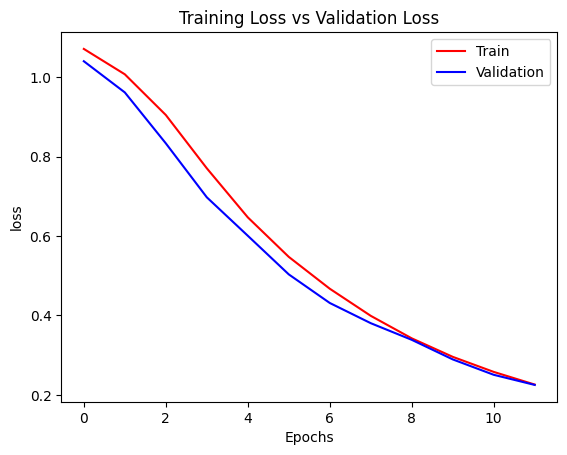

In [67]:
plt.title('Training Loss vs Validation Loss')
plt.plot(history.history['loss'], color='red', label='Train')
plt.plot(history.history['val_loss'], color='blue', label='Validation')

plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

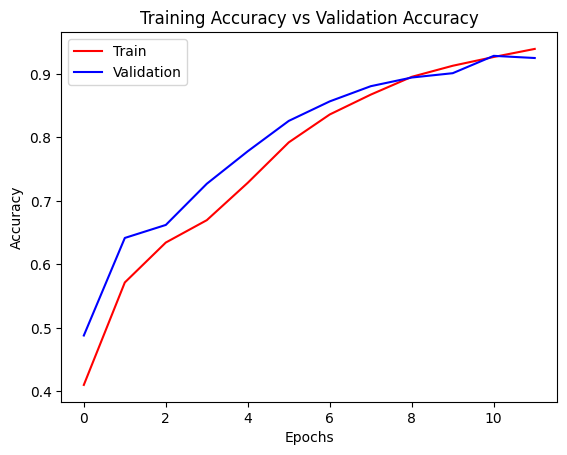

In [68]:
plt.title('Training Accuracy vs Validation Accuracy')
plt.plot(history.history['accuracy'], color='red', label='Train')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

> evalution 

In [69]:
test_loss_multi, test_accuracy_multi = multiclass_model.evaluate(multiclass_test_gen)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 481ms/step - accuracy: 0.9362 - loss: 0.2167


In [70]:
print(f"Loss: {test_loss_multi}")
print(f"Accuracy: {test_accuracy_multi}")


Loss: 0.22036758065223694
Accuracy: 0.9387755393981934


In [71]:
y_pred_probs = multiclass_model.predict(multiclass_test_gen) 

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step


In [72]:
y_pred = y_pred_probs.argmax(axis=1)

In [73]:
y_true = multiclass_test_gen.classes  

**0: cyst , 1: stone , 2 : tumor**

In [74]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       111
           1       0.92      0.81      0.86        69
           2       0.97      0.99      0.98       114

    accuracy                           0.94       294
   macro avg       0.94      0.92      0.93       294
weighted avg       0.94      0.94      0.94       294



In [75]:
results_df = pd.DataFrame({
    'True_Label': y_true,
    'Predicted_Label': y_pred
})

In [76]:
results_df.head(10)

True_Label  Predicted_Label
0           0                0
1           0                0
2           2                2
3           2                2
4           0                0
5           1                0
6           1                1
7           0                0
8           2                2
9           2                2

In [77]:
label_map = {v: k for k, v in multiclass_test_gen.class_indices.items()}
results_df['True_Label_Name'] = results_df['True_Label'].map(label_map)
results_df['Predicted_Label_Name'] = results_df['Predicted_Label'].map(label_map)

In [78]:
results_df

True_Label  Predicted_Label True_Label_Name Predicted_Label_Name
0             0                0            Cyst                 Cyst
1             0                0            Cyst                 Cyst
2             2                2           Tumor                Tumor
3             2                2           Tumor                Tumor
4             0                0            Cyst                 Cyst
..          ...              ...             ...                  ...
289           0                0            Cyst                 Cyst
290           2                2           Tumor                Tumor
291           0                0            Cyst                 Cyst
292           1                2           Stone                Tumor
293           2                2           Tumor                Tumor

[294 rows x 4 columns]

In [79]:
cm = confusion_matrix(y_true, y_pred)

In [80]:
class_names = list(multiclass_test_gen.class_indices.keys())

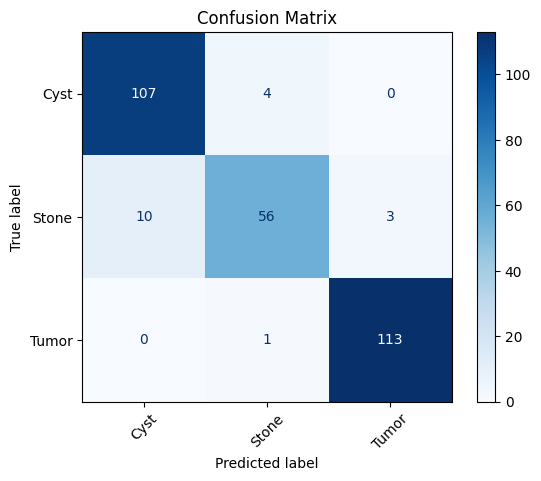

In [81]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

In [82]:
test_images, test_labels = next(multiclass_test_gen)
predictions = multiclass_model.predict(test_images).argmax(axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  


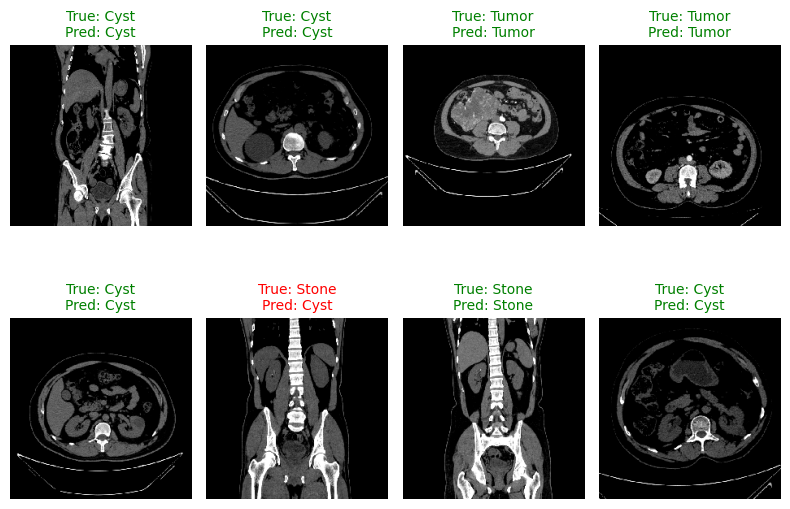

In [83]:
num_images = 8
rows, cols = 2, 4  
plt.figure(figsize=(8, 6)) 

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    img = test_images[i]
    img = (img * 255).astype(np.uint8)
    plt.imshow(img)
    true_label = label_map[test_labels[i].argmax()]
    predicted_label = label_map[predictions[i]]
    title_color = "green" if true_label == predicted_label else "red"
    plt.title(
        f"True: {true_label}\nPred: {predicted_label}",
        color=title_color,
        fontsize=10
    )
    plt.axis("off")  
    
plt.tight_layout()
plt.show()

# pretrained model VGG16

> ***binary***

In [84]:
pretrained_model_binary = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(224, 224, 3),
    weights= None
)

pretrained_model_binary.trainable = False

VGG_model_binary = Sequential([
    pretrained_model_binary,                         
    Conv2D(64, (3, 3), activation='relu', padding='same'),  
    MaxPooling2D((2, 2)),                             
    Flatten(),                                         
    Dense(64, activation='relu'),                   
    Dense(32, activation='relu'),                    
    Dense(1, activation='sigmoid')                  
])

In [85]:
VGG_model_binary.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [86]:
VGG_history = VGG_model_binary.fit(
    binary_train_gen, 
    epochs = 8, 
    validation_data =binary_val_gen)

Epoch 1/8
154/154 ━━━━━━━━━━━━━━━━━━━━ 86s 435ms/step - accuracy: 0.5303 - loss: 0.6882 - val_accuracy: 0.8135 - val_loss: 0.6146
Epoch 2/8
154/154 ━━━━━━━━━━━━━━━━━━━━ 49s 302ms/step - accuracy: 0.7829 - loss: 0.5099 - val_accuracy: 0.8464 - val_loss: 0.3826
Epoch 3/8
154/154 ━━━━━━━━━━━━━━━━━━━━ 49s 304ms/step - accuracy: 0.8506 - loss: 0.3728 - val_accuracy: 0.8556 - val_loss: 0.3328
Epoch 4/8
154/154 ━━━━━━━━━━━━━━━━━━━━ 50s 309ms/step - accuracy: 0.8653 - loss: 0.3192 - val_accuracy: 0.8940 - val_loss: 0.2658
Epoch 5/8
154/154 ━━━━━━━━━━━━━━━━━━━━ 49s 305ms/step - accuracy: 0.8874 - loss: 0.2664 - val_accuracy: 0.9104 - val_loss: 0.2141
Epoch 6/8
154/154 ━━━━━━━━━━━━━━━━━━━━ 49s 306ms/step - accuracy: 0.9165 - loss: 0.2115 - val_accuracy: 0.9360 - val_loss: 0.1658
Epoch 7/8
154/154 ━━━━━━━━━━━━━━━━━━━━ 49s 303ms/step - accuracy: 0.9345 - loss: 0.1698 - val_accuracy: 0.9506 - val_loss: 0.1211
Epoch 8/8
154/154 ━━━━━━━━━━━━━━━━━━━━ 48s 297ms/step - accuracy: 0.9536 - loss: 0.1272 - 

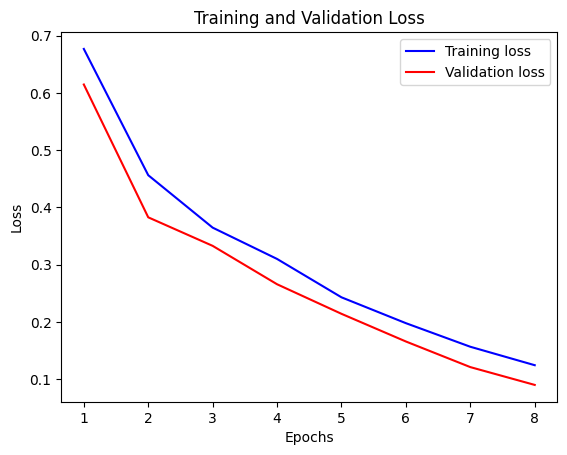

In [87]:
loss = VGG_history.history['loss']
val_loss = VGG_history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

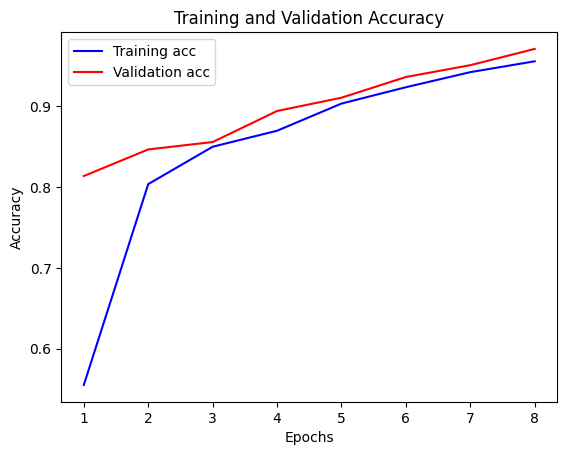

In [88]:
acc = VGG_history.history['accuracy']
val_acc = VGG_history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [89]:
test_loss_binaryV, test_accuracy_binaryV = VGG_model_binary.evaluate(binary_test_gen)

9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9657 - loss: 0.1176


In [90]:
print(f"Loss: {test_loss_binaryV}")
print(f"Accuracy: {test_accuracy_binaryV}")

Loss: 0.11818905174732208
Accuracy: 0.9635036587715149


In [91]:
y_pred = VGG_model_binary.predict(binary_test_gen)  
y_pred = (y_pred > 0.5).astype(int)

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step


In [92]:
y_true = binary_test_gen.classes

In [93]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       254
           1       0.97      0.97      0.97       294

    accuracy                           0.96       548
   macro avg       0.96      0.96      0.96       548
weighted avg       0.96      0.96      0.96       548



In [94]:
results_df = pd.DataFrame({
    'True_Label': y_true,
    'Predicted_Label': y_pred.flatten()
})

In [95]:
results_df

True_Label  Predicted_Label
0             1                1
1             0                0
2             1                1
3             1                1
4             1                1
..          ...              ...
543           0                0
544           1                1
545           1                1
546           1                1
547           1                1

[548 rows x 2 columns]

In [96]:
cm = confusion_matrix(y_true, y_pred)

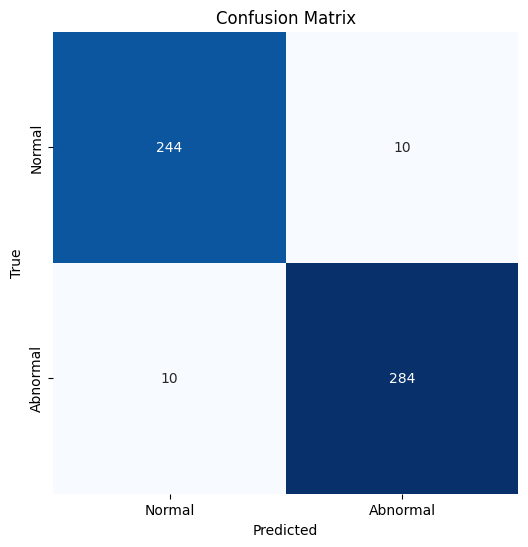

In [97]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [98]:
sample_images, sample_labels = next(binary_test_gen)

In [99]:
sample_predictions = VGG_model_binary.predict(sample_images)
sample_predictions = (sample_predictions > 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step


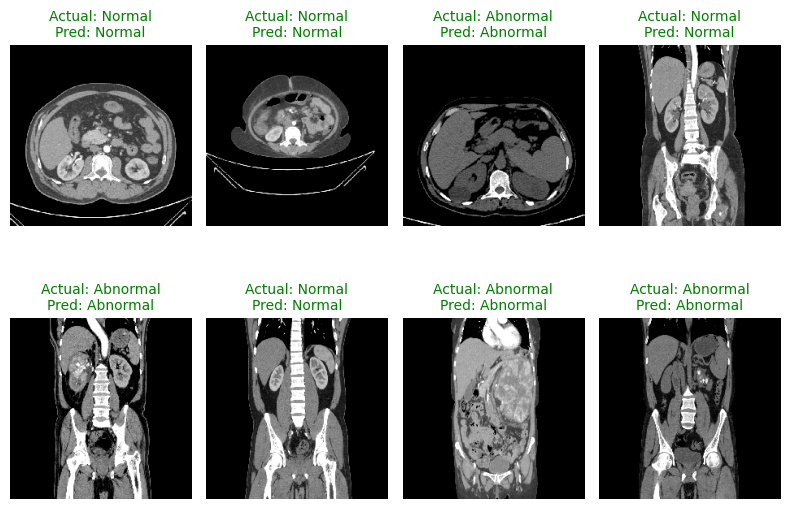

In [100]:
num_images = 8  
plt.figure(figsize=(8, 6))
rows, cols = 2, 4 
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(sample_images[i])
    actual_label = 'Normal' if sample_labels[i] == 0 else 'Abnormal'
    predicted_label = 'Normal' if sample_predictions[i] == 0 else 'Abnormal'
    label_color = "green" if sample_labels[i] == sample_predictions[i] else "red"
    plt.title(
        f"Actual: {actual_label}\nPred: {predicted_label}",
        color=label_color, 
        fontsize=10
    )
    
    plt.axis("off")  
    
plt.tight_layout()
plt.show()

> ***multiclassification***

In [101]:
pretrained_model_multi = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(224, 224, 3),
    weights= None
)

pretrained_model_multi.trainable = False

VGG_model_multi = Sequential([
    pretrained_model_multi,                         
    Conv2D(64, (3, 3), activation='relu', padding='same'),  
    MaxPooling2D((2, 2)),                             
    Flatten(),                                         
    Dense(64, activation='relu'),                   
    Dense(32, activation='relu'),                    
    Dense(3, activation='softmax')                  
])

In [102]:
VGG_model_multi.compile(optimizer=Adam(learning_rate=0.001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [103]:
history= VGG_model_multi.fit(multiclass_train_gen,
                     validation_data=multiclass_val_gen,
                     epochs=13 )

Epoch 1/13
83/83 ━━━━━━━━━━━━━━━━━━━━ 46s 500ms/step - accuracy: 0.3862 - loss: 1.0809 - val_accuracy: 0.3891 - val_loss: 1.0665
Epoch 2/13
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 299ms/step - accuracy: 0.4404 - loss: 1.0599 - val_accuracy: 0.5427 - val_loss: 0.9691
Epoch 3/13
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 304ms/step - accuracy: 0.6160 - loss: 0.9130 - val_accuracy: 0.6928 - val_loss: 0.7225
Epoch 4/13
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 302ms/step - accuracy: 0.6910 - loss: 0.7073 - val_accuracy: 0.7338 - val_loss: 0.6058
Epoch 5/13
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 307ms/step - accuracy: 0.7300 - loss: 0.6182 - val_accuracy: 0.7747 - val_loss: 0.5333
Epoch 6/13
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 290ms/step - accuracy: 0.7497 - loss: 0.5723 - val_accuracy: 0.7679 - val_loss: 0.5157
Epoch 7/13
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 301ms/step - accuracy: 0.7856 - loss: 0.5015 - val_accuracy: 0.8362 - val_loss: 0.4115
Epoch 8/13
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 288ms/step - accuracy: 0.8500 - loss: 0.4094 - val_accu

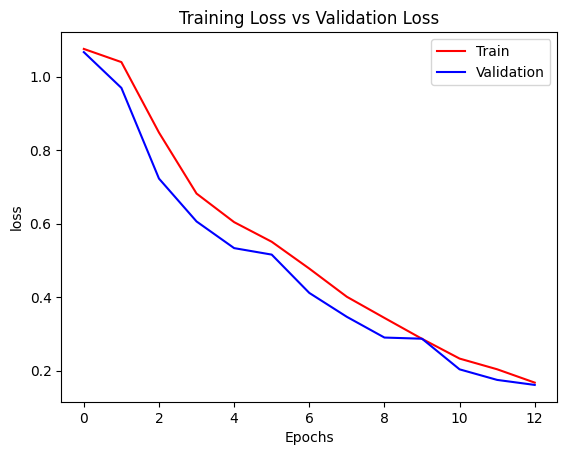

In [104]:
plt.title('Training Loss vs Validation Loss')
plt.plot(history.history['loss'], color='red', label='Train')
plt.plot(history.history['val_loss'], color='blue', label='Validation')

plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

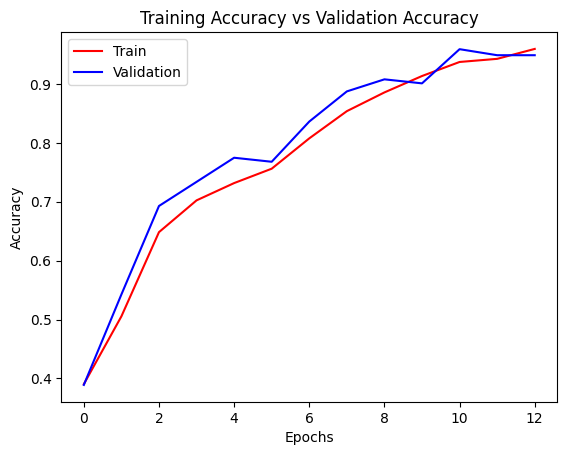

In [105]:
plt.title('Training Accuracy vs Validation Accuracy')
plt.plot(history.history['accuracy'], color='red', label='Train')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [106]:
test_loss_multiV, test_accuracy_multiV = VGG_model_multi.evaluate(multiclass_test_gen)

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9603 - loss: 0.1555


In [107]:
print(f"Loss: {test_loss_multiV}")
print(f"Accuracy: {test_accuracy_multiV}")

Loss: 0.16443558037281036
Accuracy: 0.9523809552192688


In [108]:
y_pred_probs = VGG_model_multi.predict(multiclass_test_gen) 
y_pred = y_pred_probs.argmax(axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step


In [109]:
y_true = multiclass_test_gen.classes 

In [110]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.94       111
           1       0.98      0.81      0.89        69
           2       1.00      0.99      1.00       114

    accuracy                           0.95       294
   macro avg       0.96      0.93      0.94       294
weighted avg       0.96      0.95      0.95       294



In [111]:
results_df = pd.DataFrame({
    'True_Label': y_true,
    'Predicted_Label': y_pred
})

In [112]:
results_df

True_Label  Predicted_Label
0             0                0
1             0                0
2             2                2
3             2                2
4             0                0
..          ...              ...
289           0                0
290           2                2
291           0                0
292           1                0
293           2                2

[294 rows x 2 columns]

In [113]:
label_map = {v: k for k, v in multiclass_test_gen.class_indices.items()}
results_df['True_Label_Name'] = results_df['True_Label'].map(label_map)
results_df['Predicted_Label_Name'] = results_df['Predicted_Label'].map(label_map)

In [114]:
results_df

True_Label  Predicted_Label True_Label_Name Predicted_Label_Name
0             0                0            Cyst                 Cyst
1             0                0            Cyst                 Cyst
2             2                2           Tumor                Tumor
3             2                2           Tumor                Tumor
4             0                0            Cyst                 Cyst
..          ...              ...             ...                  ...
289           0                0            Cyst                 Cyst
290           2                2           Tumor                Tumor
291           0                0            Cyst                 Cyst
292           1                0           Stone                 Cyst
293           2                2           Tumor                Tumor

[294 rows x 4 columns]

In [115]:
cm = confusion_matrix(y_true, y_pred)

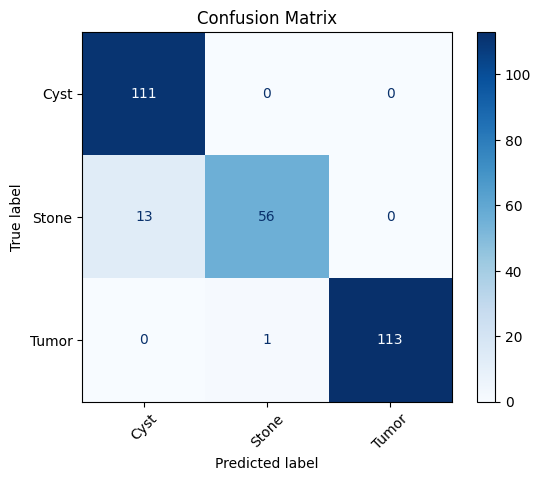

In [116]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

In [117]:
test_images, test_labels = next(multiclass_test_gen)
predictions = VGG_model_multi.predict(test_images).argmax(axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


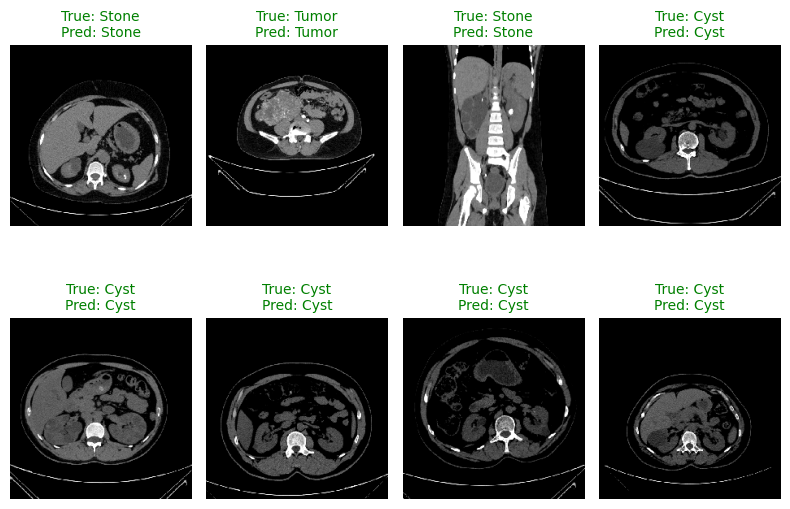

In [118]:
num_images = 8
rows, cols = 2, 4  
plt.figure(figsize=(8, 6)) 

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    img = test_images[i]
    img = (img * 255).astype(np.uint8)
    plt.imshow(img)
    true_label = label_map[test_labels[i].argmax()]
    predicted_label = label_map[predictions[i]]
    title_color = "green" if true_label == predicted_label else "red"
    plt.title(
        f"True: {true_label}\nPred: {predicted_label}",
        color=title_color,
        fontsize=10
    )
    plt.axis("off")  
    
plt.tight_layout()
plt.show()

# save models 

In [119]:
multiclass_model.save('multiclass_model_final.h5')
binary_model.save('binary_model_final.h5')

In [120]:
VGG_model_binary.save('VGG_model_binary_final.h5')
VGG_model_multi.save('VGG_model_multi_final.h5')

# prediction function

> for from scratch

In [121]:
binary_model = load_model('binary_model_final.h5')
multiclass_model = load_model('multiclass_model_final.h5')

In [122]:
def predict_pipeline(image_path, binary_model, multiclass_model):
    img = load_img(image_path, target_size=(224, 224))  
    img_array = img_to_array(img) / 255.0 
    img_array = np.expand_dims(img_array, axis=0)  
    
    binary_pred = binary_model.predict(img_array)
    if binary_pred > 0.5:
        multiclass_pred = multiclass_model.predict(img_array)
        class_idx = np.argmax(multiclass_pred) 
        
        class_labels = {0: 'Cyst', 1: 'Stone', 2: 'Tumor'}
        return f"Abnormal: {class_labels[class_idx]}"
    else:
        return "Normal"

In [123]:
image_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1024).jpg"
result = predict_pipeline(image_path, binary_model, multiclass_model)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Abnormal: Tumor


> for VGG16

In [124]:
VGG_model_binary = load_model('VGG_model_binary_final.h5')
VGG_model_multi = load_model('VGG_model_multi_final.h5')

In [125]:
def predict_pipeline_vgg(image_path, VGG_binary, VGG_multi):
    img = load_img(image_path, target_size=(224, 224))  
    img_array = img_to_array(img) / 255.0 
    img_array = np.expand_dims(img_array, axis=0)  
    
    binary_pred = VGG_model_binary.predict(img_array)
    if binary_pred > 0.5:
        multiclass_pred = VGG_model_multi.predict(img_array)
        class_idx = np.argmax(multiclass_pred) 
        
        class_labels = {0: 'Cyst', 1: 'Stone', 2: 'Tumor'}
        return f"Abnormal: {class_labels[class_idx]}"
    else:
        return "Normal"

In [126]:
image_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1024).jpg"
result = predict_pipeline_vgg(image_path, binary_model, multiclass_model)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
Abnormal: Tumor
